In [1]:
from qiskit_nature.problems.sampling.protein_folding.peptide.peptide import Peptide
from qiskit_nature.problems.sampling.protein_folding.penalty_parameters import PenaltyParameters
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import ProteinFoldingProblem
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit import execute, Aer
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit.algorithms import VQE

In [2]:
### 1. Defining a protein

main_chain = "APRLRFY" #Alanine,Proline,Arginine,Leucine,Arginine,Phenylalanine,Tyrosine / 7 amino acids
chain_len = len(main_chain)
side_chains = [""] * chain_len # seven empty side chains = no side chains 
protein1 = Peptide(main_chain, side_chains)

In [3]:
### 2. The interaction method

#from qiskit_nature.problems.sampling.protein_folding.interactions.miyazawa_jernigan_interaction import(
# MiyazawaJerniganInteraction) 

def validate_main_chain(main_chain: str):
    for amino_acid in main_chain:
        if validate_amino_acid(amino_acid) == False:
            return False
    return True

def validate_amino_acid(amino_acid: str) -> bool:
    valid_amino_acids = [
        "A",  # Alanine
        "C",  # Cysteine
        "D",  # Aspartic acid
        "E",  # Glutamic acid
        "F",  # Phenylalanine
        "G",  # Glycine
        "H",  # Histidine
        "I",  # Isoleucine
        "K",  # Lysine
        "L",  # Leucine
        "M",  # Methionine
        "N",  # Asparagine
        "P",  # Proline
        "Q",  # Glutamine
        "R",  # Arginine
        "S",  # Serine
        "T",  # Threonine
        "V",  # Valine
        "W",  # Tryptophan
        "Y",  # Tyrosine
    ]
    if amino_acid != "" and amino_acid not in valid_amino_acids:
        return False
    return True

from pathlib import Path
import os
import numpy as np
from typing import Tuple, List

def path_of_mj():
    path1 = Path().parent.absolute()
    path2 = Path("resources")
    path1 = os.path.join(path1, path2)
    filename = "mj_matrix.txt"
    path = os.path.normpath(os.path.join(path1, filename))
    return path

def load_mj_matrix() -> Tuple[np.ndarray, List[str]]:
    path = path_of_mj()
    matrix = np.loadtxt(fname=path, dtype=str)
    mj_matrix = np.zeros((np.shape(matrix)[0], np.shape(matrix)[1]))
    for row in range(1, np.shape(matrix)[0]):
        for col in range(row - 1, np.shape(matrix)[1]):
            mj_matrix[row, col] = float(matrix[row, col])
    mj_matrix = mj_matrix[1:,]
    amino_acids = list(matrix[0, :])
    return mj_matrix, amino_acids

class MiyazawaJerniganInteraction():
    def calculate_energy_matrix(self, main_chain: str) -> np.ndarray:
            chain_len = len(main_chain)
            validate_main_chain(main_chain)
            mj_matrix, list_amino_acids = load_mj_matrix() 
            energy_matrix = np.zeros((chain_len + 1, 2, chain_len + 1, 2)) 
            for i in range(1, chain_len + 1):
                for j in range(i + 1, chain_len + 1):
                    aa_i = list_amino_acids.index(main_chain[i - 1])
                    aa_j = list_amino_acids.index(main_chain[j - 1])
                    energy_matrix[i, 0, j, 0] = mj_matrix[min(aa_i, aa_j), max(aa_i, aa_j)] 
            return energy_matrix

miyazawa_jernigan = MiyazawaJerniganInteraction()

In [4]:
energy_matrix1 = miyazawa_jernigan.calculate_energy_matrix(main_chain)
energy_matrix1

array([[[[ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ]],

        [[ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ]]],


       [[[ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [-2.03,  0.  ],
         [-1.83,  0.  ],
         [-4.91,  0.  ],
         [-1.83,  0.  ],
         [-4.81,  0.  ],
         [-3.36,  0.  ]],

        [[ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ]]],


       [[[ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [ 0.  ,  0.  ],
         [-1.7 ,  0.  ],
         [-4.2 ,  0.  ],
         [-1.7 ,  0.  ],
         [-4.25,  0.  ],
         [-3.

In [5]:
energy_matrix2 = np.zeros((chain_len, chain_len))
for i in range(chain_len):
    for j in range(chain_len):
        energy_matrix2[i][j] = energy_matrix1[i + 1, 0, j + 1, 0]

print("           A      P      R      L      R      F      Y")
energy_matrix2

           A      P      R      L      R      F      Y


array([[ 0.  , -2.03, -1.83, -4.91, -1.83, -4.81, -3.36],
       [ 0.  ,  0.  , -1.7 , -4.2 , -1.7 , -4.25, -3.19],
       [ 0.  ,  0.  ,  0.  , -4.03, -1.55, -3.98, -3.16],
       [ 0.  ,  0.  ,  0.  ,  0.  , -4.03, -7.28, -5.67],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -3.98, -3.16],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -5.66],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [6]:
### 3. Penalty terms
penalty_terms = PenaltyParameters(10,10,10) #(penalty_chiral, penalty_back, penalty_1)

### using ProteinFoldingProblem Function
protein_folding_1 = ProteinFoldingProblem(protein1, miyazawa_jernigan, penalty_terms)
qubit_operations_1 = protein_folding_1.qubit_op()
print(qubit_operations_1)

1613.5895000000003 * IIIIIIIII
- 701.802 * ZIIIIIIII
- 904.2875 * IZIIIIIII
+ 192.5 * IIZIIIIII
- 200.0 * ZIZIIIIII
+ 7.5 * IZZIIIIII
+ 105.0 * IIIZIIIII
- 105.0 * ZIIZIIIII
+ 95.0 * IIZZIIIII
- 100.0 * ZIZZIIIII
+ 5.0 * IZZZIIIII
- 497.5 * IIIIZIIII
+ 195.0 * ZIIIZIIII
+ 302.5 * IZIIZIIII
- 95.0 * IIZIZIIII
+ 100.0 * ZIZIZIIII
- 2.5 * IZZIZIIII
- 100.0 * IIIIIZIII
+ 102.5 * ZIIIIZIII
- 2.5 * IZIIIZIII
- 95.0 * IIIZIZIII
+ 100.0 * ZIIZIZIII
- 2.5 * IZIZIZIII
- 300.0 * IIIIZZIII
+ 97.5 * ZIIIZZIII
+ 202.5 * IZIIZZIII
- 95.0 * IIZZZZIII
+ 100.0 * ZIZZZZIII
- 2.5 * IZZZZZIII
+ 487.5 * IIIIIIZII
- 195.0 * ZIIIIIZII
- 295.0 * IZIIIIZII
+ 97.5 * IIZIIIZII
- 100.0 * ZIZIIIZII
+ 2.5 * IZZIIIZII
- 195.0 * IIIIZIZII
+ 97.5 * ZIIIZIZII
+ 100.0 * IZIIZIZII
+ 100.0 * IIIIIIIZI
- 102.5 * ZIIIIIIZI
+ 2.5 * IZIIIIIZI
+ 97.5 * IIIZIIIZI
- 100.0 * ZIIZIIIZI
+ 2.5 * IZIZIIIZI
- 195.0 * IIIIIZIZI
+ 97.5 * ZIIIIZIZI
+ 100.0 * IZIIIZIZI
+ 295.0 * IIIIIIZZI
- 97.5 * ZIIIIIZZI
- 197.5 * IZIIIIZZI
+ 97.5 * IIZ

In [7]:
### 1. ansatz
ansatz = RealAmplitudes(reps=1)

### 2. optimizer
optimizer = COBYLA(maxiter=50)

### 3. backend
backend = "aer_simulator"
backend = QuantumInstance(
    Aer.get_backend(backend),
    shots=1000,
)

### callback function
counts = []
values = []

def callback_function(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    
    
### expectation
cvar_exp = CVaRExpectation(0.1, PauliExpectation())

### VQE using CVaR
vqe = VQE(
    expectation=cvar_exp,
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
    callback=callback_function,
)

result = vqe.compute_minimum_eigenvalue(qubit_operations_1)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': {   '000100101': 0.044721359549995794,
                      '000101101': 0.03162277660168379,
                      '001000011': 0.05477225575051661,
                      '001000100': 0.044721359549995794,
                      '001000101': 0.15491933384829668,
                      '001000111': 0.11832159566199232,
                      '001001011': 0.08366600265340755,
                      '001010101': 0.06324555320336758,
                      '001010111': 0.03162277660168379,
                      '001100011': 0.130384048104053,
                      '001100100': 0.06324555320336758,
                      '001100101': 0.2024845673131659,
                      '001100111': 0.16431676725154984,
                      '001101001': 0.044721359549995794,
                      '001101010': 0.03162277660168379,
                      '001101011': 0.24083189157584592,
                      '001101101': 

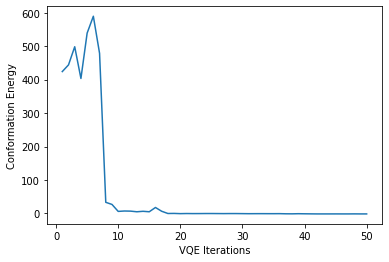

In [8]:
import matplotlib.pyplot as plt

figure = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

plt.show()